# DATA620 Final Project A
## Network Analysis

# Project Description
***

We would like to find businesses (or ideally people) who are influential in drawing foreign and domestic investment in Myanmar.  Through basic network analysis techniques, we hope to find a clique of people or companies with common investment sources or common activities.

# Data Description
***

This data was scraped and realeased anonymously from official government sources in two leaks called Myanmar Financials and Myanmar Investments.  The former is incorporation documents for ~125k companies, and the latter is information from investment proposals for about 10k companies.

# Known Challenges
***

1. About 1/4 of the companies in Myanmar Financials paid somebody to approve their incorporation documents without addresses or names... We can remove companies with no listed officers.

2. People in Myanmar are named for astrological information pertaining to their birth.  There is no family name, and many people have the same names.  We also cannot do anything about this.

3. A small number of names are given in Burmese script, which is included in UTF-8, but is unreadable to our team.  We can leave the script as-is, and remove punctuation.

4. Most companies did not apply for investment approval.  We will focus only on companies with investment records.

# Method
***

1. Import and clean the data
2. Create an edge list:
> |Company Name |People
> --- | --- 
> |companyNameInMyanmar |officers, landOwner, nameOfInvestor
3. Project bipartite graph, view statistics
4. Trim edges, weighted by number of names per company
5. Visualize

In [17]:
import os
import scipy
from pathlib import *
import json
import pandas as pd
import networkx as nx
from networkx.algorithms import bipartite
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup
import re
import string
from collections import defaultdict
from itertools import combinations

In [2]:
# Company incorporation documents
com_dir = Path('/home/s/fpa/data/company_info')
# Investment proposals and information about real projects
inv_dir = Path('/home/s/fpa/data/investment_info')

# Helper Functions
***
#### pathToList()
- Takes a Path object for a directory full of JSON files
- Returns a list containing a dict for each file read in

#### companyInfo()
- Takes a list of dicts
- Extracts copmany name and names of officers
- Returns a DataFrame with this information

#### investmentInfo()
- Takes a list of lists of dicts
- Converts dicts to DataFrames
- Returns list of DataFrames

#### cleanDF()
- Takes a DataFrame
- Converts all letters to lowercase
- Substitutes ltd with limited
- Removes all punctuation

#### defineEdges()
- Takes company information and a list of other DataFrames
- Creates dictionary with key company name and value list of people
- Adds investors to edge list
- Returns edge list dictionary

#### expandEdges()
- Takes a dictionary of company nodes with lists of connected people
- Returns a list of edges with only two nodes on each line

#### trimEdges()

#### islandMethod()

In [3]:
def pathToList(path_obj):
    file_list = []
    for file_path in path_obj.iterdir():
        data = json.loads(file_path.read_bytes())
        file_list.append(data)
    return(file_list)

def companyInfo(com_list):
    info_list = []
    # Iterate over all companies in the list
    for i in range(len(com_list)):
        info = {}
        # Extract Company Name to "companyNameInMyanmar"
        info['companyNameInMyanmar'] = com_list[i]['Corp']['CompanyName']
        # Extract Officer names
        for b in range(len(com_list[i]['Officers'])):
            info['officer' + str(b)] = com_list[i]['Officers'][b]['FullNameNormalized']
        # Convert to DataFrame
        info_list.append(info)
    df = pd.DataFrame.from_dict(info_list, orient = 'columns')
    return(df)

def investmentInfo(inv_list):
    investments = []
    # Extract data from investment documents
    for i in range(len(inv_list)):
        d = pd.DataFrame.from_dict(
            [x for x in inv_list[i]['data']], orient = 'columns')
        investments.append(d)
    return(investments)

def cleanDF(df):
    # Convert to lowercase
    df = df.applymap(str)
    df = df.applymap(lambda s:s.lower())
    # ltd -> limited
    df = df.applymap(lambda s:s.replace('ltd', 'limited'))
    # Remove punctuation
    df = df.applymap(lambda s:s.translate(str.maketrans('', '', string.punctuation)))         
    # Strip trailing spaces
    #df = df.applymap(lambda s:s.strip)
    return(df)

def defineEdges(companies, investments):
    edges = {}
    # add companies with investment applications to the list
    for doc in investments:
        doc = cleanDF(doc)
        for i in range(len(doc)):
            co = doc.iloc[i]['companyNameInMyanmar']
            inv = doc.iloc[i]['nameOfInvestor']
            # add remaining companies to edge list
            if co not in edges.keys():
                edges[co] = []
            # add investors as connections
            if inv not in edges[co]:
                edges[co].append(str(inv).replace(' ', ''))
            # add company officers to the list
    for i in range(len(companies)):
        if companies.iloc[i, 0] in edges.keys():
        # add officers as connections
            for j in range(1,68):
                officer = companies.iloc[i,j]
                if officer != 'nan':
                    edges[co].append(officer)
                else:
                    break
    return(edges)

def expandEdges(edges):
    expanded_edges = []
    for company in edges:
        for person in company:
            edge = (company, person)
            expanded_edges.append(edge)
    return(expanded_edges)

def trimEdges(G, weight = 1):
    G2 = nx.Graph()
    edata = nx.to_pandas_edgelist(G)
    f = edata['source']
    to = edata['target']
    
    for f, to, edata in G.edges(data = True):
        if edata['weight'] > weight:
            G2.add_edge(f, to)
    return G2

def islandMethod(g, iterations = 5):
    weights = [edata['weight'] for f, to, edata in g.edges(data = True)]
    mn = int(min(weights))
    mx = int(max(weights))
    step = int((mx - mn) / iterations)
    return([[threshold, trimEdges(g, threshold)]
           for threshold in range(mn, mx, step)])

# Preprocessing
***

In [4]:
companies = cleanDF(companyInfo(pathToList(com_dir)))
# Drop rows with no names
companies = companies[companies.officer0 != 'nan']

investments = investmentInfo(pathToList(inv_dir))
edges = defineEdges(companies, investments)
expanded_edges = expandEdges(edges)

reversed_edges = defaultdict(list)
for key, value in edges.items():
    for item in value:
        reversed_edges[item].append(key)

# Network Analysis
***

In [6]:
G = nx.Graph()

company_nodes = edges.keys()
people_nodes = reversed_edges.keys()

G.add_nodes_from(company_nodes, bipartite = 'Companies')
G.add_nodes_from(people_nodes, bipartite = 'People')
G.add_edges_from(expanded_edges)

G.number_of_nodes()

7177

In [7]:
G.number_of_edges()

47465

In [13]:
P = bipartite.weighted_projected_graph(G, people_nodes)

In [9]:
P.number_of_edges()

6879

In [14]:
islands_P = islandMethod(P)

for i in islands_P:
    print('Threshold: ' + str(i[0]))
    print('Number of Nodes: ' + str(len(i[1])))
    print('Length of Connected Components')
    display(pd.DataFrame(pd.Series([len(c) for c in sorted(nx.connected_components(i[1]), key=len)]).value_counts().sort_index()).T)
    print()

Threshold: 1
Number of Nodes: 2747
Length of Connected Components


,78,2669
0,1,1



Threshold: 478
Number of Nodes: 20
Length of Connected Components


,20
0,1



Threshold: 955
Number of Nodes: 17
Length of Connected Components


,17
0,1



Threshold: 1432
Number of Nodes: 14
Length of Connected Components


,14
0,1



Threshold: 1909
Number of Nodes: 13
Length of Connected Components


,13
0,1



Threshold: 2386
Number of Nodes: 2
Length of Connected Components


,2
0,1


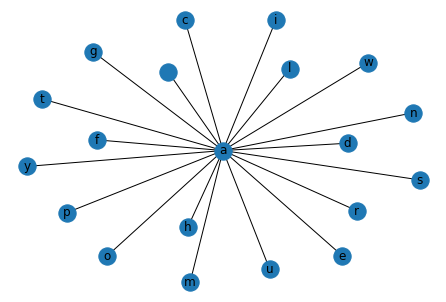

In [21]:
island = islands_P[1][1]
nx.draw(island, with_labels = True)
plt.show()